# Assignment 2: Detecting Linux system hacking activities

#### Student Name: Soyeon Kim

## Table of Contents
* [1. Data preparation and exploration](#one)
    * [1.1 Creating Spark Session](#one1)
    * [1.2 Loading the data](#one2)
    * [1.3 Exploring the data](#one3)
* [2. Feature extraction and ML training](#two) 
    * [2.1 Preparing the training data and testing data](#two1)
    * [2.2 Preparing features, labels and models](#two2)
    * [2.3 Training and evaluating models](#two3)
* [3. Knowledge sharing](#three) 

<a class="anchor" name="one"></a>
## 1. Data preparation and exploration

<a class="anchor" name="one1"></a>
## 1.1 Creating Spark Session

#### 1. Create a SparkConf object for using as many local cores as possible, for a proper application name, and for changing the max partition byte configuration to enable a minimum of 2 partitions when reading each file in Spark SQL (so each dataframe should have at least 4 partitions when reading from the given datafiles).

In [1]:
from pyspark import SparkConf

master = "local[*]"
app_name = "Detecting Linux system hacking activities"
spark_conf = SparkConf().setMaster(master)\
                        .setAppName(app_name)\
                        .set("spark.sql.files.maxPartitionBytes", 40000000) # more than "max file size/2" 

#### 2. Then create a SparkSession using the SparkConf object.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

<a class="anchor" name="one2"></a>
## 1.2 Loading the data

#### 1. Load each activity data into a Spark dataframe and cache the data. Then print out the row count of each dataframe.
#### ○ In order to speed up the loading process, please specify the schema before reading the data into dataframes. You may find relevant schema info from the metadata file, however, note that some data may not fully comply with the schema. For those that do not comply with the schema, import them as StringType and further transform them in step 1.2.2.

#### <li>  Process activity

In [3]:
from pyspark.sql.types import StructType, StructField,  StringType, IntegerType, DoubleType, BinaryType

In [4]:
# schema of process activity
process_schema = StructType([
    StructField("ts", IntegerType(), True),      
    StructField("PID", IntegerType(), True),
    StructField("TRUN", IntegerType(), True),
    StructField("TSLPI", IntegerType(), True),
    StructField("TSLPU", IntegerType(), True),
    StructField("POLI", StringType(), True),
    StructField("NICE", IntegerType(), True),
    StructField("PRI", IntegerType(), True),
    StructField("RTPR", IntegerType(), True),
    StructField("CPUNR", IntegerType(), True),
    StructField("Status", StringType(), True),
    StructField("EXC", IntegerType(), True),
    StructField("State", StringType(), True),
    StructField("CPU", DoubleType(), True),
    StructField("CMD", StringType(), True),
    StructField("attack", IntegerType(), True),
    StructField("type", StringType(), True),
])

In [5]:
# Load each csv file for process activity
process_df = spark.read.format('csv')\
            .option('header',True)\
            .option('escape','"')\
            .schema(process_schema)\
            .load('linux_process_*.csv')

In [6]:
# Cache the data
process_df.cache()

DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: double, CMD: string, attack: int, type: string]

In [7]:
# Check the number of partitions of process_df
process_df.rdd.getNumPartitions()

4

In [8]:
# row count of process_df
process_df.count()

1927968

In [9]:
# have a look at the data of process_df
process_df.show(10)

+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+--------------+------+------+
|        ts| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State| CPU|           CMD|attack|  type|
+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+--------------+------+------+
|1556739928|2579|   0|    1|    0|norm|   0|120|   0|    0|     -|  0|    S| 0.0|upstart-dbus-b|     0|normal|
|1556739933|3739|   0|    1|    0|norm|   0|120|   0|    0|     -|  0|    S| 0.0|   kworker/0:1|     0|normal|
|1556739938|3752|   0|    4|    0|norm|   0|120|   0|    1|     -|  0|    S| 0.0|gnome-terminal|     0|normal|
|1556739943|2596|   0|    4|    0|norm|   0|120|   0|    3|     -|  0|    S| 0.0|unity-settings|     0|normal|
|1556739948|1400|   0|    1|    0|norm|   0|120|   0|    2|     -|  0|    S| 0.0|    irqbalance|     0|normal|
|1556739953|3793|   1|   10|    0|norm|   0|120|   0|    0|     -|  0|    S|1.01|         drone|     0|normal|
|

#### <li>  Memory activity

In [10]:
# schema of memory activity
memory_schema = StructType([
    StructField("ts", IntegerType(), True),        
    StructField("PID", IntegerType(), True),
    StructField("MINFLT", DoubleType(), True),
    StructField("MAJFLT", DoubleType(), True),
    StructField("VSTEXT", DoubleType(), True),
    StructField("VSIZE", DoubleType(), True),
    StructField("RSIZE", DoubleType(), True),
    StructField("VGROW", DoubleType(), True),
    StructField("RGROW", DoubleType(), True),
    StructField("MEM", DoubleType(), True),    
    StructField("CMD", StringType(), True),
    StructField("attack", IntegerType(), True),
    StructField("type", StringType(), True),
])

In [11]:
# Load each csv file for memory activity
memory_df = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .schema(memory_schema)\
            .load('linux_memory_*.csv')

In [12]:
# Cache the data
memory_df.cache()

DataFrame[ts: int, PID: int, MINFLT: double, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: int, type: string]

In [13]:
# Check the number of partitions of memory_df
memory_df.rdd.getNumPartitions()

4

In [14]:
# row count of memory_df
memory_df.count()

2000000

In [15]:
# have a look at the data of memory_df
memory_df.show(10)

+----------+----+------+------+------+-------+------+-----+-----+---+--------------+------+------+
|        ts| PID|MINFLT|MAJFLT|VSTEXT|  VSIZE| RSIZE|VGROW|RGROW|MEM|           CMD|attack|  type|
+----------+----+------+------+------+-------+------+-----+-----+---+--------------+------+------+
|1556743448|2123|   9.0|   0.0| 596.0|  191.7|4712.0|  0.0|  0.0|0.0|       apache2|     0|normal|
|1556743453|2925|   0.0|   0.0| 350.0|  315.3|4596.0|  0.0|  0.0|0.0|mission-contro|     0|normal|
|1556743458|1192|   2.0|   0.0|1071.0|  342.1|4528.0|  0.0|  0.0|0.0|NetworkManager|     0|normal|
|1556743463|1404|   0.0|   0.0|  47.0|  505.2|3584.0|  0.0|  0.0|0.0|      whoopsie|     0|normal|
|1556743468|3238|   0.0|   0.0|  18.0|  368.9|3516.0|  0.0|  0.0|0.0|deja-dup-monit|     0|normal|
|1556743473|3897|1928.0|   0.0| 148.0|17944.0|2604.0|  0.0|  0.0|0.0|          atop|     0|normal|
|1556743478|3894|1927.0|   0.0| 148.0|17664.0|2480.0|  0.0|  0.0|0.0|          atop|     0|normal|
|155674348

#### 2. For each column in each dataframe above,

#### ○ Check the null data (if any) and print out the corresponding count in each column

In [16]:
from pyspark.sql.functions import isnan, when, count, col

#### <li>  Process activity

In [17]:
# check the null data in process_df
process_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in process_df.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



#### <li>  Memory activity

In [18]:
# check the null data in memory_df
memory_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memory_df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|  9737|  8800|  8800|    0| 9728|49552| 9737|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



#### ○ Are these columns 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW' in memory data following the datatype from the metadata file? If not, please transform them into the proper formats

No they don't follow the datatype from the metadata file, since they have a large number of null values. To investigate what these null values originally are, and how they become null, we will import those columns as StringType and do the further transformations.

In [19]:
# change the schema of memory activity
memory_schema_new = StructType([
    StructField("ts", IntegerType(), True),         
    StructField("PID", IntegerType(), True),
    StructField("MINFLT", StringType(), True),
    StructField("MAJFLT", StringType(), True),
    StructField("VSTEXT", StringType(), True),
    StructField("VSIZE", DoubleType(), True),
    StructField("RSIZE", StringType(), True),
    StructField("VGROW", StringType(), True),
    StructField("RGROW", StringType(), True),
    StructField("MEM", DoubleType(), True),    
    StructField("CMD", StringType(), True),
    StructField("attack", IntegerType(), True),
    StructField("type", StringType(), True),
])

In [20]:
# Load each csv file for memory activity following the new schema
memory_df_new = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .schema(memory_schema_new)\
            .load('linux_memory_*.csv')

In [21]:
# Cache the data
memory_df_new.cache()

DataFrame[ts: int, PID: int, MINFLT: string, MAJFLT: string, VSTEXT: string, VSIZE: double, RSIZE: string, VGROW: string, RGROW: string, MEM: double, CMD: string, attack: int, type: string]

In [22]:
# check the null data in memory_df_new
memory_df_new.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memory_df_new.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



We will explore each of those columns to check what the null values were.

##### <li> 'MINFLT'

In [23]:
# check the data of records with null values in the column
memory_df.where(col("MINFLT").isNull()).show(10)

+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|    CMD|attack|  type|
+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|1556203721|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203726|10001|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203731|10002|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203741|10004|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203746|10005|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203751|10006|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203756|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556204676|10137|  null|   0.0|   0.0|  0.0| null| null| null|0.0| <find>|     0|normal|
|155620468

In [24]:
# By referring to the above dataframe, we can check what the null values were
memory_df_new.select("MINFLT").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new.select("MINFLT").filter((col("ts")==1556204686)&(col("PID")==10139)).show()

+------+
|MINFLT|
+------+
|  132K|
+------+

+------+
|MINFLT|
+------+
|    0K|
+------+



The "K" appears to be causing the problem. I will convert not only K but also M and G to the correspoding number unit. It is possible to include spaces in the middle of numbers, so they will be deleted as well. 
Finally, the column type will be changed from string to numeric according to the metadata file.

In [25]:
from pyspark.sql.functions import regexp_replace

In [26]:
memory_df_new_1 = memory_df_new.withColumn("MINFLT", when(col('MINFLT').like("%K"), (regexp_replace('MINFLT', 'K', '').cast('double')*1000))\
                                .when(col('MINFLT').like("%M"), (regexp_replace('MINFLT', 'M', '').cast('double')*1000000))\
                                .when(col('MINFLT').like("%G"), (regexp_replace('MINFLT', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('MINFLT', ' ', '').cast('double'))))

In [27]:
# Check the same data after transformation
memory_df_new_1.select("MINFLT").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_1.select("MINFLT").filter((col("ts")==1556204686)&(col("PID")==10139)).show()

+--------+
|  MINFLT|
+--------+
|132000.0|
+--------+

+------+
|MINFLT|
+------+
|   0.0|
+------+



##### <li>'MAJFLT'

In [28]:
# check the data of records with null values in the column
memory_df.where(col("MAJFLT").isNull()).show(10)

+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|    CMD|attack|  type|
+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|1556203721|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203726|10001|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203731|10002|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203741|10004|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203746|10005|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203751|10006|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203756|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556205276|10002|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|155620539

In [29]:
# By referring to the above dataframe, we can check what the null values were
memory_df_new_1.select("MAJFLT").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_1.select("MAJFLT").filter((col("ts")==1556203751)&(col("PID")==10006)).show()

+------+
|MAJFLT|
+------+
|224.2M|
+------+

+------+
|MAJFLT|
+------+
|224.2M|
+------+



It seems that null values have occurred for the same reason as the column above. So, in this column, we will do the same transformation we did earlier.

In [30]:
memory_df_new_2 = memory_df_new_1.withColumn("MAJFLT", when(col('MAJFLT').like("%K"), (regexp_replace('MAJFLT', 'K', '').cast('double')*1000))\
                                .when(col('MAJFLT').like("%M"), (regexp_replace('MAJFLT', 'M', '').cast('double')*1000000))\
                                .when(col('MAJFLT').like("%G"), (regexp_replace('MAJFLT', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('MAJFLT', ' ', '').cast('double'))))

In [31]:
# Check the same data after transformation
memory_df_new_2.select("MAJFLT").filter((col("ts")==1554990670)&(col("PID")==16752)).show()
memory_df_new_2.select("MAJFLT").filter((col("ts")==1556203751)&(col("PID")==10006)).show()

+------+
|MAJFLT|
+------+
| 146.1|
+------+

+-------+
| MAJFLT|
+-------+
|2.242E8|
+-------+



##### <li> 'VSTEXT'

In [32]:
# check the data of records with null values in the column
memory_df.where(col("VSTEXT").isNull()).show(10)

+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|    CMD|attack|  type|
+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|1556203721|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203726|10001|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203731|10002|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203741|10004|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203746|10005|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203751|10006|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203756|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556205276|10002|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|155620539

In [33]:
# By referring to the above dataframe, we can check what the null values were
memory_df_new_2.select("VSTEXT").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_2.select("VSTEXT").filter((col("ts")==1556203726)&(col("PID")==10001)).show()

+------+
|VSTEXT|
+------+
| 9392K|
+------+

+------+
|VSTEXT|
+------+
| 9392K|
+------+



It seems that null values have occurred for the same reason as the column above. So, in this column, we will do the same transformation we did earlier.

In [34]:
memory_df_new_3 = memory_df_new_2.withColumn("VSTEXT", when(col('VSTEXT').like("%K"), (regexp_replace('VSTEXT', 'K', '').cast('double')*1000))\
                                .when(col('VSTEXT').like("%M"), (regexp_replace('VSTEXT', 'M', '').cast('double')*1000000))\
                                .when(col('VSTEXT').like("%G"), (regexp_replace('VSTEXT', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('VSTEXT', ' ', '').cast('double'))))

In [35]:
# Check the same data after transformation
memory_df_new_3.select("VSTEXT").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_3.select("VSTEXT").filter((col("ts")==1556203726)&(col("PID")==10001)).show()

+---------+
|   VSTEXT|
+---------+
|9392000.0|
+---------+

+---------+
|   VSTEXT|
+---------+
|9392000.0|
+---------+



##### <li> 'RSIZE'

In [36]:
# check the data of records with null values in the column
memory_df.where(col("RSIZE").isNull()).show(10)

+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|    CMD|attack|  type|
+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|1556203721|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203726|10001|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203731|10002|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203741|10004|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203746|10005|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203751|10006|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203756|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556204676|10137|  null|   0.0|   0.0|  0.0| null| null| null|0.0| <find>|     0|normal|
|155620468

In [37]:
# By referring to the above dataframe, we can check what the null values were
memory_df_new_3.select("RSIZE").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_3.select("RSIZE").filter((col("ts")==1556204686)&(col("PID")==10139)).show()

+------+
| RSIZE|
+------+
|224.2M|
+------+

+-----+
|RSIZE|
+-----+
|   0K|
+-----+



It seems that null values have occurred for the same reason as the column above. So, in this column, we will do the same transformation we did earlier.

In [38]:
memory_df_new_4 = memory_df_new_3.withColumn("RSIZE", when(col('RSIZE').like("%K"), (regexp_replace('RSIZE', 'K', '').cast('double')*1000))\
                                .when(col('RSIZE').like("%M"), (regexp_replace('RSIZE', 'M', '').cast('double')*1000000))\
                                .when(col('RSIZE').like("%G"), (regexp_replace('RSIZE', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('RSIZE', ' ', '').cast('double'))))

In [39]:
# Check the same data after transformation
memory_df_new_4.select("RSIZE").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_4.select("RSIZE").filter((col("ts")==1556204686)&(col("PID")==10139)).show()

+-------+
|  RSIZE|
+-------+
|2.242E8|
+-------+

+-----+
|RSIZE|
+-----+
|  0.0|
+-----+



##### <li> 'VGROW'

In [40]:
# check the data of records with null values in the column
memory_df.where(col("VGROW").isNull()).show(10)

+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|    CMD|attack|  type|
+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|1556203721|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203726|10001|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203731|10002|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203741|10004|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203746|10005|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203751|10006|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203756|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556204676|10137|  null|   0.0|   0.0|  0.0| null| null| null|0.0| <find>|     0|normal|
|155620468

In [41]:
# By referring to the above dataframe, we can check what the null values were
memory_df_new_4.select("VGROW").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_4.select("VGROW").filter((col("ts")==1556204686)&(col("PID")==10139)).show()

+-----+
|VGROW|
+-----+
|9392K|
+-----+

+-----+
|VGROW|
+-----+
|   0K|
+-----+



It seems that null values have occurred for the same reason as the column above. So, in this column, we will do the same transformation we did earlier.

In [42]:
memory_df_new_5 = memory_df_new_4.withColumn("VGROW", when(col('VGROW').like("%K"), (regexp_replace('VGROW', 'K', '').cast('double')*1000))\
                                .when(col('VGROW').like("%M"), (regexp_replace('VGROW', 'M', '').cast('double')*1000000))\
                                .when(col('VGROW').like("%G"), (regexp_replace('VGROW', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('VGROW', ' ', '').cast('double'))))

In [43]:
# Check the same data after transformation
memory_df_new_5.select("VGROW").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_5.select("VGROW").filter((col("ts")==1556204686)&(col("PID")==10139)).show()

+---------+
|    VGROW|
+---------+
|9392000.0|
+---------+

+-----+
|VGROW|
+-----+
|  0.0|
+-----+



##### <li> 'RGROW' 

In [44]:
# check the data of records with null values in the column
memory_df.where(col("RGROW").isNull()).show(10)

+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|    CMD|attack|  type|
+----------+-----+------+------+------+-----+-----+-----+-----+---+-------+------+------+
|1556203721|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203726|10001|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203731|10002|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203741|10004|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203746|10005|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203751|10006|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556203756|10000|  null|  null|  null|  0.0| null| null| null|0.0|apache2|     0|normal|
|1556204676|10137|  null|   0.0|   0.0|  0.0| null| null| null|0.0| <find>|     0|normal|
|155620468

In [45]:
# By referring to the above dataframe, we can check what the null values were
memory_df_new_5.select("RGROW").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_5.select("RGROW").filter((col("ts")==1556203726)&(col("PID")==10001)).show()

+-----+
|RGROW|
+-----+
|   0K|
+-----+

+-----+
|RGROW|
+-----+
|   0K|
+-----+



It seems that null values have occurred for the same reason as the column above. So, in this column, we will do the same transformation we did earlier.

In [46]:
memory_df_new_6 = memory_df_new_5.withColumn("RGROW", when(col('RGROW').like("%K"), (regexp_replace('RGROW', 'K', '').cast('double')*1000))\
                                .when(col('RGROW').like("%M"), (regexp_replace('RGROW', 'M', '').cast('double')*1000000))\
                                .when(col('RGROW').like("%G"), (regexp_replace('RGROW', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('RGROW', ' ', '').cast('double'))))

In [47]:
# Check the same data after transformation
memory_df_new_6.select("RGROW").filter((col("ts")==1556203721)&(col("PID")==10000)).show()
memory_df_new_6.select("RGROW").filter((col("ts")==1556203726)&(col("PID")==10001)).show()

+-----+
|RGROW|
+-----+
|  0.0|
+-----+

+-----+
|RGROW|
+-----+
|  0.0|
+-----+



Finally, we will check the schema of the data frame and the number of null values after the transformations of the columns.

In [48]:
memory_df_final = memory_df_new_6

In [49]:
# Cache the data
memory_df_final.cache()

DataFrame[ts: int, PID: int, MINFLT: double, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: int, type: string]

In [50]:
# check the null data in memory_df_final
memory_df_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memory_df_final.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



It seems that the data types of all columns match those of the metadata file. Also, there is no null value now.

<a class="anchor" name="one3"></a>
## 1.3 Exploring the data 

####  1. Show the count of attack and non-attack in each activity based on the column “attack”, then show the count of each kind of attack in process activity based on the column “type”.

#### ○ Do you see any class imbalance? Examine and describe what you observe

In [51]:
from pyspark.sql import functions as F

#### <li>  Process activity

In [52]:
# count of attack and non-attack in process activity
process_df_count = process_df.groupby("attack").agg(F.count("attack").alias('Count'))
process_df_count.show()

+------+-------+
|attack|  Count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



- attack = 1: attack event <br>
- attack = 0: non-attack event <br>

It seems that the number of non-attack events is about 5 times more than the number of attack events, which means the distribution of the data is imbalanced.

In [53]:
# count of each kind of attack in process activity
process_df_count_type = process_df.groupby("type").agg(F.count("type").alias('Count'))
process_df_count_type.orderBy(process_df_count_type.Count).show()

+---------+-------+
|     type|  Count|
+---------+-------+
|     mitm|    112|
|      xss|  17759|
| scanning|  38449|
|injection|  41311|
| password|  51409|
|      dos|  70721|
|     ddos|  71603|
|   normal|1636604|
+---------+-------+



Compared with the data frame above, it can be inferred that 'normal' means non-attack events and the other values indicate attack events. In addition, among the attack types, in the case of mitms with the smallest number of counts and ddos with the largest number of counts, it can be checked that the difference is about 600 times or more. Also, the difference in the number of counts between the other classes is not small.

#### <li>  Memory activity

In [54]:
# count of attack and non-attack in memory activity
memory_df_final_count = memory_df_final.groupby("attack").agg(F.count("attack").alias('Count'))
memory_df_final_count.show()

+------+-------+
|attack|  Count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+



It seems that the number of non-attack events is about 8 times more than the number of attack events, which means the distribution of the data is more imbalanced than that of the process activity.

#### 2. For each numeric feature in each activity, show the basic statistics (including count, mean, stddev, min, max); for each non-numeric feature in each activity, display the top-10 values and the corresponding counts.

#### ○ No need to show the labels at “attack” or “type” column

#### <li>  Process activity

In [55]:
# check the numeric features
process_df.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [56]:
# numeric feature: count, mean, stddev, min, max

# extract numerical columns (except 'attack' column)
numeric_process =  ['ts', 'PID', 'TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'RTPR', 'CPUNR', 'EXC',  'CPU']

#Summary Statistics
process_df.describe(numeric_process).show(5)

# for readability:  process_df.describe(numeric_process).toPandas().head(5)

+-------+--------------------+-----------------+-------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+--------------------+
|summary|                  ts|              PID|               TRUN|            TSLPI|               TSLPU|             NICE|               PRI|   RTPR|             CPUNR|                 EXC|                 CPU|
+-------+--------------------+-----------------+-------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+--------------------+
|  count|             1927968|          1927968|            1927968|          1927968|             1927968|          1927968|           1927968|1927968|           1927968|             1927968|             1927968|
|   mean|1.5563198311840394E9|5068.709770597852| 0.0632287465352122|3.508334163222626|3.610018423542299...|4.634469555511295|111.26826741937626|

All columns have the same number of records. <br> <br>

- ts
: It has the largest scale and stddev. <br> <br>

- PID
: The column has the largest gap between min and max. By comparing |mean-min| to |mean-max|, it is possible that the data is concentrated on the small number side or there are outliers on the large number side.
<br> <br>
- TRUN, TSLPI, EXC, CPU
: For the same reason as the PID column, it is possible that the data is concentrated on the small number side or there are outliers on the large number side.
<br> <br>
- TSLPU
: It seems that the majority of records are likely to be distributed around 0, and large outliers exist.
<br> <br>
- NICE
: According to the metadata file, the scale of this column is from -20 (high priority) to +19 (low priority). However, from the table above, the max value of the NICE seems to be 20. We will examine the number of each value in the NICE column to find why this difference occured.
<br> <br>
- PRI
: It is possible that the data is concentrated on the large number side or there are outliers on the small number side.
<br> <br>
- RTPR
: mean = stddev = min = max = 0.It means this column only contains 0 values. For checking whether this column is valid or not, we will look at the POLI column, which is a non-numerical column related to this column according to the metadata file. 
<br><br>


In [57]:
# number of each value in the NICE column
process_df_count_NICE = process_df.groupby("NICE").agg(F.count("NICE").alias('Count'))
process_df_count_NICE.orderBy(process_df_count_NICE.Count).show() 

+----+-------+
|NICE|  Count|
+----+-------+
|  19|    116|
|  10|   1601|
|  11|   6765|
|   1|  16840|
|  20| 441282|
|   0|1461364|
+----+-------+



There is no negative value. Most likely, some negative signs were wrongly removed when the data collector extracted data. Therfore, we need to restore the correct values of the NICE column. We can use the information from the metadata file in this case: There is a mapping between PRI (priority) and NICE, as long as the process is not yet finished during the last interval. For example, PRI 100 maps to NICE -20 and PRI 139 maps to NICE 19. If the process is finished, PRI would be 0 and NICE would be 0 as well. 

First, we will check the number of each value in the PRI column.

In [58]:
# number of each value in the PRI column
process_df_count_PRI = process_df.groupby("PRI").agg(F.count("PRI").alias('Count'))
process_df_count_PRI.orderBy(process_df_count_PRI.Count).show() 

+---+-------+
|PRI|  Count|
+---+-------+
|110|     15|
|139|    116|
|130|   1586|
|109|   6765|
|121|  16840|
|  0|  66410|
|100| 441282|
|120|1394954|
+---+-------+



The NICE values corresponding to the PRI values above will be as follows.

|PRI | NICE |
|---|---|
|0 |0 |
|100 |-20 |
|109 |-11 |
|110 |-10 |
|120 |0 |
|121 |1 |
|130 |10 |
|139 |19 | 

Based on this data, we will change the value of the NICE column.<br>

https://stackoverflow.com/questions/50321549/map-values-in-a-dataframe-from-a-dictionary-using-pyspark/52015818

In [59]:
from itertools import chain
from pyspark.sql.functions import create_map, lit

In [60]:
# Create a dictionary for mapping values
valmap = {0: 0, 100: -20, 109:-11, 110:-10, 120:0, 121:1, 130:10, 139:19}

# Replace the values of the 'NICE' column
mapping_expr = create_map([lit(x) for x in chain(*valmap.items())])
process_df_final = process_df.withColumn('NICE', mapping_expr[process_df['PRI']])

# cache the data
process_df_final.cache()

# check the records after changing the data of 'NICE' column
process_df_final.show(5)

+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+------+------+
|        ts| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|           CMD|attack|  type|
+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+------+------+
|1556739928|2579|   0|    1|    0|norm|   0|120|   0|    0|     -|  0|    S|0.0|upstart-dbus-b|     0|normal|
|1556739933|3739|   0|    1|    0|norm|   0|120|   0|    0|     -|  0|    S|0.0|   kworker/0:1|     0|normal|
|1556739938|3752|   0|    4|    0|norm|   0|120|   0|    1|     -|  0|    S|0.0|gnome-terminal|     0|normal|
|1556739943|2596|   0|    4|    0|norm|   0|120|   0|    3|     -|  0|    S|0.0|unity-settings|     0|normal|
|1556739948|1400|   0|    1|    0|norm|   0|120|   0|    2|     -|  0|    S|0.0|    irqbalance|     0|normal|
+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+------+------+
only showi

Let's have a look at the NICE data.

In [61]:
process_df_final_count_NICE = process_df_final.groupby("NICE").agg(F.count("NICE").alias('Count'))
process_df_final_count_NICE.orderBy(process_df_final_count_NICE.Count).show() 

+----+-------+
|NICE|  Count|
+----+-------+
| -10|     15|
|  19|    116|
|  10|   1586|
| -11|   6765|
|   1|  16840|
| -20| 441282|
|   0|1461364|
+----+-------+



Now, the values of the NICE match the metadata and the count of the PRI values above.

Now we will look at the top 10 values for the non-numeric features of the process activity.

In [62]:
# non-numeric feature: top-10 values and the corresponding counts

# extract non-numeric columns (except 'type' column)
non_numeric_process =  ['POLI', 'Status', 'State', 'CMD']

In [63]:
#POLI
process_df_final_count_POLI = process_df_final.groupby("POLI").agg(F.count("POLI").alias('Count'))
process_df_final_count_POLI.orderBy(process_df_final_count_POLI.Count, ascending=False).show(10)

+----+-------+
|POLI|  Count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+



There are 3 classes in this feature. 
The distribution of data between each category seems to be imbalanced.

In addition, we mentioned that, the RTPR, one of the numeric columns, seems to be related to the POLI column, because RTPR's range from 1 till 99 = POLI's 'rr' or 'fifo'. Since neither 'rr' and 'fifo' exist in the current POLI column, the reason why the RTPR only had 0 values  can be explained.

In [64]:
#Status
process_df_final_count_Status = process_df_final.groupby("Status").agg(F.count("Status").alias('Count'))
process_df_final_count_Status.orderBy(process_df_final_count_Status.Count, ascending=False).show(10)

+------+-------+
|Status|  Count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+



There are 7 classes in this feature.The distribution of data between each category seems to be highly imbalanced.

In [65]:
#State
process_df_final_count_State = process_df_final.groupby("State").agg(F.count("State").alias('Count'))
process_df_final_count_State.orderBy(process_df_final_count_State.Count, ascending=False).show(10)

+-----+-------+
|State|  Count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+



There are 7 classes in this feature.The distribution of data between each category seems to be highly imbalanced.

In [66]:
#CMD
process_df_final_count_CMD = process_df_final.groupby("CMD").agg(F.count("CMD").alias('Count'))
process_df_final_count_CMD.orderBy(process_df_final_count_CMD.Count, ascending=False).show(10)

+--------------+------+
|           CMD| Count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



It seems there are more than 10 classes in this feature.

#### <li>  Memory activity

In [67]:
# check the type of features
memory_df_final.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [68]:
# numeric feature: count, mean, stddev, min, max

# extract numerical columns (except 'attack' column)
numeric_memory =  ['ts', 'PID', 'MINFLT', 'MAJFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'VGROW', 'RGROW', 'MEM']

#Summary Statistics
memory_df_final.describe(numeric_memory).show(5)

# for readability:  memory_df_final.describe(numeric_memory).toPandas().head(5)

+-------+------------------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+
|summary|                ts|              PID|            MINFLT|              MAJFLT|           VSTEXT|            VSIZE|             RSIZE|            VGROW|             RGROW|                 MEM|
+-------+------------------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+
|  count|           2000000|          2000000|           2000000|             2000000|          2000000|          2000000|           2000000|          2000000|           2000000|             2000000|
|   mean|1.55624581707609E9|      4999.360446|        983.344344|   987846.5873269099|46453.27415208399|4496.419966445697|23722.888664203034|984.4668735599994|      483.17466255|0.003385165000001...|


All columns have the same number of records. <br> <br>

- ts
: It has the largest scale. <br> <br>

- PID, MINFL, RGROW
: By comparing |mean-min| to |mean-max|, it is possible that the data is concentrated on the small number side or there are outliers on the large number side.
<br> <br>

- RSIZE, VGROW
: It has negative values.
<br> <br>

- MEM
: It seems that the majority of records are likely to be distributed around 0.
<br> <br>

Now we will look at the top 10 values for the non-numeric feature of the memory activity.

In [69]:
# non-numeric feature: top-10 values and the corresponding counts

# extract non-numeric columns (except 'type' column)
non_numeric_memory =  'CMD'

# top-10 values and the corresponding counts
memory_df_final_count_CMD = memory_df_final.groupby("CMD").agg(F.count("CMD").alias('Count'))
memory_df_final_count_CMD.orderBy(memory_df_final_count_CMD.Count, ascending=False).show(10)

+----------+------+
|       CMD| Count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



It seems 'atop' has an overwhelmingly larger number of counts than other classes.

#### 3. For each activity, present two plots worthy of presenting to the StopHacking company, describe your plots and discuss the findings from the plots

#### ○ Hint - 1: you can use the basic plots (e.g. histograms, line charts, scatter plots) for relationship between a column and the “attack” label (such as “ts” and “attack”, “PID” and “attack”); or more advanced plots like correlation plots for relationship between each column; 2: if your data is too large for the plotting, consider using sampling before plotting

#### ○ 100 words max for each plot’s description and discussion

In [70]:
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install dython

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dython import nominal

#### <li>  Process activity

In [71]:
# for making it easy to plot, convert a spark dataframe to pandas dataframe
process_df_pandas = process_df_final.toPandas()

First, we will look at the relationship between the numeric columns through a correlation matrix plot using Pearson's correlation coefficient.

https://datascience.stackexchange.com/questions/14356/is-a-correlation-matrix-meaningful-for-a-binary-classification-task

<AxesSubplot:>

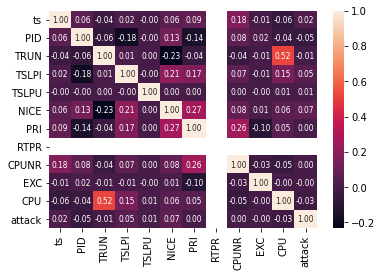

In [72]:
# draw a correlation plot between numeric values 
corr_process = process_df_pandas.corr()
sns.heatmap(corr_process, xticklabels=corr_process.columns, yticklabels=corr_process.columns, 
            annot= True, fmt=".2f", annot_kws={"size":7.5})

![](http://www.uow.edu.au/content/groups/public/@web/@stsv/documents/mm/uow153493.gif)

http://www.uow.edu.au/content/groups/public/@web/@stsv/documents/mm/uow153493.gif

* According to the table above, we will look for variables with a correlation of more than moderate level . From the plot above,it seems that TRUN and CPU have a moderate positive correlation. What we need to considere here is that when there is a correlation between independent variables, the problem of multicollinearity may appear, which can affect the performance of models negatively. <br> <br>

* The data corresponding to the RTPR column, which had only 0 values, is empty. This is related to how the correlation coefficient is calculated as, follows: <br><br> $\frac{cov(i,j)}{stddev(i)*stddev(j)}$ <br><br> If the values of the ith or jth variable do not vary, then the respective standard deviation will be zero and so will the denominator of the fraction. Thus, the correlation will be NaN. 

https://stackoverflow.com/questions/22655667/dataframe-correlation-produces-nan-although-its-values-are-all-integers

In fact, our target variable, attack, is numeric, but it is close to binary class, so it is not appropriate to use Pearson's coefficient. 
To see if the above plot can be referenced for the target variable as well, we will use Point Biserial Correlation to calculate the correlation between the continuous variable and the categorical variable. 

https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1

In [73]:
from scipy.stats import pointbiserialr

In [74]:
pointbiserialr(process_df_pandas['attack'], process_df_pandas['ts'])

PointbiserialrResult(correlation=0.023794559374089447, pvalue=1.9154714409441995e-239)

In [75]:
pointbiserialr(process_df_pandas['attack'], process_df_pandas['PID'])

PointbiserialrResult(correlation=-0.05364267840368056, pvalue=0.0)

In [76]:
pointbiserialr(process_df_pandas['attack'], process_df_pandas['TSLPI'])

PointbiserialrResult(correlation=0.051909464848070824, pvalue=0.0)

It seems the correlation coeffecients are similar to those in the plot, thus we can refer to the plot for the target variable as well. However, there seems to be no feature which is correlated with the attack attribute.

Now, we will plot the correlation between categorical variable using Cramer's V

https://github.com/shakedzy/dython/issues/2

/home/student/.local/lib/python3.8/site-packages/pandas/core/frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


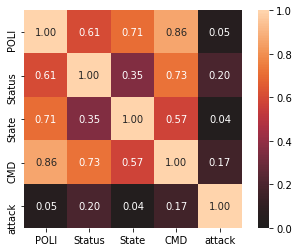

{'corr':             POLI    Status     State       CMD    attack
 POLI    1.000000  0.608415  0.707105  0.864860  0.049269
 Status  0.608415  1.000000  0.352136  0.725013  0.201897
 State   0.707105  0.352136  1.000000  0.573465  0.035817
 CMD     0.864860  0.725013  0.573465  1.000000  0.169426
 attack  0.049269  0.201897  0.035817  0.169426  1.000000,
 'ax': <AxesSubplot:>}

In [77]:
# draw a correlation plot between non-numeric values 
nominal.associations(process_df_pandas[['POLI', 'Status', 'State', 'CMD', 'attack']], nominal_columns='all')

It seemes there are more correlated non-numeric variables than numeric-variables. The State and POLI, CMD and Status, Status and POLI, and CMD and State, have a moderate positive correlation. Moreover, the CMD and POLI have a strong positive correlation. On the other hand, there is no feature which is correlated with the target variable. It should be noted that when categorical variables are converted to dummy variables, multicollinearity can occur, like continuous variables do.

#### <li> Memory activity

In [78]:
# for making it easy to plot, convert a spark dataframe to pandas dataframe
memory_df_pandas = memory_df_final.toPandas()

<AxesSubplot:>

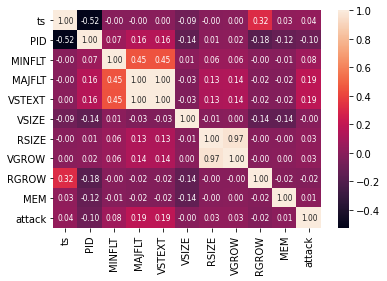

In [79]:
# draw a correlation plot 
corr_memory = memory_df_pandas.corr()
sns.heatmap(corr_memory, xticklabels=corr_memory.columns, yticklabels=corr_memory.columns, 
            annot= True, fmt=".2f", annot_kws={"size":7.5})

From the plot above, it seems that VSTEXT and MAJFLT, and RSIZE and VGROW, have such a strong positive correlation. In particular, the correlation coefficient between VSTEXT and MAJFLT is equal to 1. In addtion, there is moderate negative correlation between ts and PID. However, the attack seems to be not highly correlated to any feature.

/home/student/.local/lib/python3.8/site-packages/pandas/core/frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


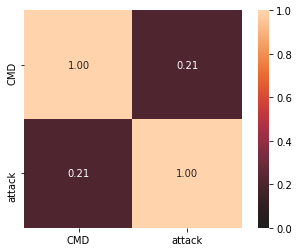

{'corr':              CMD    attack
 CMD     1.000000  0.213625
 attack  0.213625  1.000000,
 'ax': <AxesSubplot:>}

In [80]:
nominal.associations(memory_df_pandas[['CMD', 'attack']], nominal_columns='all')

It seems the CMD is not significantly correlated with the target attribute, attack.

<a class="anchor" name="two"></a>
## 2. Feature extraction and ML training

<a class="anchor" name="two1"></a>
## 2.1 Preparing the training data and testing data

#### 1. Randomly split the dataset into 80% training data and 20% testing data for each use case

In [81]:
# process activity
train_process, test_process = process_df_final.randomSplit([0.8, 0.2])

# memory activity
train_memory, test_memory = memory_df_final.randomSplit([0.8, 0.2])

#### 2. With the class imbalance observed from 1.3.1, for the binary classification use case 1 & 2, prepare rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using 20% attack events data from the training data from 2.1.1. Cache the rebalanced training data, and display the count of each event's data.

#### ○ Hint - you can use undersampling to get the rebalanced training data

https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253

In [82]:
from pyspark.sql.functions import explode, array

#### <li> Process data

In [83]:
# calculate ratio
major_df_process = train_process.filter(col("attack") == 0)
minor_df_process = train_process.filter(col("attack") == 1)
ratio_df_process = int(major_df_process.count()/minor_df_process.count())
print("Before undersampling, attack: non-attack = 1:",ratio_df_process)

Before undersampling, attack: non-attack = 1: 5


In [84]:
# using 20% attack events data from the training data
sampled_minority_df_process_attack = minor_df_process.sample(False, 0.2)
combined_df_process_attack = sampled_minority_df_process_attack.unionAll(major_df_process)

In [85]:
# calculate ratio
major_process_attack = combined_df_process_attack.filter(col("attack") == 0)
minor_process_attack = combined_df_process_attack.filter(col("attack") == 1)
ratio_process_attack = int(major_process_attack.count()/minor_process_attack.count())
print("After undersampling, attack: non-attack = 1:", ratio_process_attack)

After undersampling, attack: non-attack = 1: 28


In [86]:
# attack events and non-attack events being 1:2 ratio
sampled_majority_df_process = major_process_attack.sample(False, 1/14)
combined_df_process= sampled_majority_df_process.unionAll(minor_process_attack)

In [87]:
major_process = combined_df_process.filter(col("attack") == 0)
minor_process= combined_df_process.filter(col("attack") == 1)
ratio_process = int(major_process.count()/minor_process.count())
print("After undersampling, attack: non-attack = 1:", ratio_process)

After undersampling, attack: non-attack = 1: 2


In [88]:
# Cache the rebalanced training data
combined_df_process.cache()

DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: double, CMD: string, attack: int, type: string]

In [89]:
# count of attack and non-attack in process activity
combined_df_process_count = combined_df_process.groupby("attack").agg(F.count("attack").alias('Count'))
combined_df_process_count.show()

+------+-----+
|attack|Count|
+------+-----+
|     1|46739|
|     0|93865|
+------+-----+



#### <li> Memory data

In [90]:
# calculate ratio
major_df_memory = train_memory.filter(col("attack") == 0)
minor_df_memory = train_memory.filter(col("attack") == 1)
ratio_df_memory = int(major_df_memory.count()/minor_df_memory.count())
print("Before undersampling, attack: non-attack = 1:",ratio_df_memory)

Before undersampling, attack: non-attack = 1: 8


In [91]:
# using 20% attack events data from the training data
sampled_minority_df_memory_attack = minor_df_memory.sample(False, 0.2)
combined_df_memory_attack = sampled_minority_df_memory_attack.unionAll(major_df_memory)

In [92]:
# calculate ratio
major_memory_attack = combined_df_memory_attack.filter(col("attack") == 0)
minor_memory_attack = combined_df_memory_attack.filter(col("attack") == 1)
ratio_memory_attack = int(major_memory_attack.count()/minor_memory_attack.count())
print("After undersampling, attack: non-attack = 1:", ratio_memory_attack)

After undersampling, attack: non-attack = 1: 43


In [93]:
# attack events and non-attack events being 1:2 ratio
sampled_majority_df_memory = major_memory_attack.sample(False, 1/21)
combined_df_memory= sampled_majority_df_memory.unionAll(minor_memory_attack)

In [94]:
# calculate ratio
major_memory = combined_df_memory.filter(col("attack") == 0)
minor_memory= combined_df_memory.filter(col("attack") == 1)
ratio_memory = int(major_memory.count()/minor_memory.count())
print("After undersampling, attack: non-attack = 1:", ratio_memory)

After undersampling, attack: non-attack = 1: 2


In [95]:
# Cache the rebalanced training data
combined_df_memory.cache()

DataFrame[ts: int, PID: int, MINFLT: double, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: int, type: string]

In [96]:
# count of attack and non-attack in memory activity
combined_df_memory_count = combined_df_memory.groupby("attack").agg(F.count("attack").alias('Count'))
combined_df_memory_count.show()

+------+-----+
|attack|Count|
+------+-----+
|     1|32785|
|     0|68568|
+------+-----+



<a class="anchor" name="two2"></a>
## 2.2 Preparing features, labels and models

#### 1. Based on data exploration from 1.3.3, which features would you select? Discuss the reason for selecting them and how you plan to further transform them.

#### <li> Process data

* Numeric features 

1. Remove RTPR column: It only contains 0 values with 0 stddev. Thus, it will be not meaningful when building a model. <br><br>

2. Remove TRUN column: We found that TRUN and CPU are correlated. It indicates there might be a multicollinearity issue if we utilize both of them. Therefore, we will only use one of them when building models. In this case, the CPU will be selected, since it has a higer correlation with the target variable than that of the TRUN.

To check whether there are variables that need preprocessing, we will draw a box plot of numeric variables excluding RTPR and TRUN.

https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog

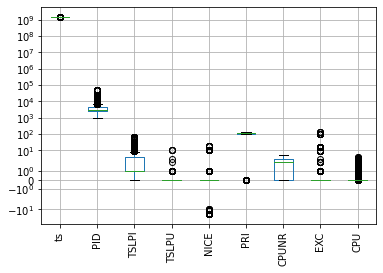

In [97]:
# take a symlog for comparison
train_process_pd = combined_df_process.toPandas()
numeric_process_new =  ['ts', 'PID', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'CPUNR', 'EXC', 'CPU']
feature_numeric_process = train_process_pd.loc[:, numeric_process_new]
feature_numeric_process.boxplot()
plt.xticks(rotation=90)
plt.yscale('symlog')

In the case of TSLPU, NICE, and CPU, it seems that most of the values are concentrated in a very narrow range. These columns are likely to have skewed data. On the other hand, the ts and PID have significantly larger scales than other variables. Since most attributes are overshadowed by these attributes, scaling process should be proceeded. However, since we will use a decision tree and gradient boosted tree, which do not require normalization or standardization processes seperately, we will not pre-process the data of these variables.<br><br>
In conclusion, all features themselves, will be used for building the models, except RTPR and TRUN.

https://www.quora.com/Is-multicollinearity-a-problem-in-decision-trees

https://towardsdatascience.com/a-guide-to-decision-trees-for-machine-learning-and-data-science-fe2607241956

https://medium.com/cracking-the-data-science-interview/decision-trees-how-to-optimize-my-decision-making-process-e1f327999c7a
https://ai-times.tistory.com/149

* Non-numeric features

We have found that: <br>
* strong positive correlation: CMD & POLI <br>
* moderate positive correlation: <br>
  - State & POLI <br>
  - CMD & Status <br>
  - Status & POLI <br>
  - CMD & State <br> <br>
  
Based on the strength of each correlation between features, or between each feature and attack variable, we will only select CMD and Status. Both features are not ordinal categorical variables, so we will choose one-hot encoding transformation.

https://blogs.ashrithgn.com/basic-encoding-label-encoding-and-one-hot-encoding-in-scala-with-apache-spark/

#### <li> Memory data

* Numeric features <br>

1. Remove MAJFLT: The VSTEXT and MAJFLT are strongly correlated. Also, these attributes have the same correlation coefficients for the target variable. Thus, we will randomly keep one of them, in this case, VSTEXT. <br><br>
2. Remove VGROW: The RSIZE and VGROW are strongly correlated. In addition, they have the same correlation coefficients for the attack column. Therefore, only one of those variables will be selected randomly, in this case, RSIZE. <br><br>
3. Keep both ts and PID: The ts and PID are moderately correlated. Thus, we can remove one of them. However, they did not have a high correlation in process activity, we will keep both features here. 

Boxplot will be drawed to check the distribution and scale of each numeric variable.

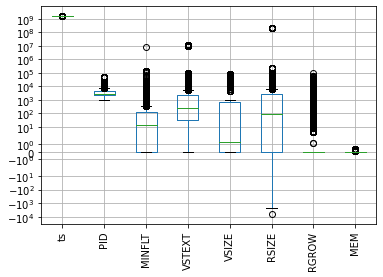

In [98]:
# take a symlog for comparison
train_memory_pd = combined_df_memory.toPandas()
numeric_memory_new =  ['ts', 'PID', 'MINFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'RGROW', 'MEM']
feature_numeric_memory = train_memory_pd.loc[:, numeric_memory_new]
feature_numeric_memory.boxplot()
plt.xticks(rotation=90)
plt.yscale('symlog')

It is observed that, for the RGROW, there are a large number of outliers and most of the values are concentrated in a very narrow range. On the other hand, it seems that the ts has significantly larger scales than other variables. For the same reason as mentioned in the process activity above, standardization and normalization will not be performed for these columns.

In short, 'ts', 'PID', 'MINFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'RGROW' and 'MEM' will be selected among the numeric features.

* Non-numeric features

There is only one non-numeric feature in memory activity. Since it is not an ordinal categorical variable, the one-hot encoding transformation will be proceeded.

#### 2. Create Transformers / Estimators for transforming / assembling the features you selected above in 2.2.1

#### <li> Process activity

In [99]:
# numeric columns & attack
numeric_process_attack = ['ts', 'PID', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'CPUNR', 'EXC',  'CPU', 'attack']

# non-numeric columns
non_numerics_process = ['Status', 'CMD']

In [100]:
# StringIndexer for categorical values
from pyspark.ml.feature import StringIndexer

inputCols = [x for x in non_numerics_process]
outputCols = [f'{x}_index' for x in inputCols]

stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols).setHandleInvalid("keep")

In [101]:
# One hot encoder for categorical values
from pyspark.ml.feature import OneHotEncoder

inputCols_OHE = [x for x in outputCols]
outputCols_OHE = [f'{x}_vec' for x in inputCols]

stage_2 = OneHotEncoder(inputCols=inputCols_OHE, outputCols=outputCols_OHE)

In [102]:
# VectorAssembler for all features
from pyspark.ml.feature import VectorAssembler

inputCols_VA= outputCols_OHE +[x for x in numeric_process_attack if x!='attack']
stage_3 = VectorAssembler(inputCols=inputCols_VA, outputCol='features')

#### <li> Memory activity

In [103]:
# numeric columns & attack
numeric_memory_attack =  ['ts', 'PID', 'MINFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'RGROW', 'MEM', 'attack']

# non-numeric columns 
non_numerics_memory =  ['CMD']

In [104]:
# StringIndexer for categorical values

inputCols_memory = [x for x in non_numerics_memory]
outputCols_memory = [f'{x}_index' for x in inputCols_memory]

stage_1_memory = StringIndexer(inputCols=inputCols_memory, outputCols=outputCols_memory).setHandleInvalid("keep")

In [105]:
# One hot encoder for categorical values

inputCols_OHE_memory = [x for x in outputCols_memory]
outputCols_OHE_memory = [f'{x}_vec' for x in inputCols_memory]

stage_2_memory = OneHotEncoder(inputCols=inputCols_OHE_memory, outputCols=outputCols_OHE_memory)

In [106]:
# VectorAssembler for all features

inputCols_VA_memory = outputCols_OHE_memory +[x for x in numeric_memory_attack if x!='attack']
stage_3_memory = VectorAssembler(inputCols=inputCols_VA_memory, outputCol='features')

#### 3. Prepare Estimators for Decision Tree and Gradient Boosted Tree model for each use case and include them into ML Pipelines for use case 1, 2

#### <li> Process activity

* Decision Tree

In [107]:
from pyspark.ml.classification import DecisionTreeClassifier

In [108]:
dt_process = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)

In [109]:
from pyspark.ml import Pipeline

In [110]:
#Implement the PipelineAPI
pipeline_process_dt = Pipeline(stages=[stage_1, stage_2, stage_3, dt_process])

* Gradient Boosted Tree

In [111]:
from pyspark.ml.classification import GBTClassifier

In [112]:
gbt_process = GBTClassifier(featuresCol="features", labelCol="attack", maxIter=10)

In [113]:
#Implement the PipelineAPI
pipeline_process_gbt = Pipeline(stages=[stage_1, stage_2, stage_3, gbt_process])

https://medium.com/@aieeshashafique/gradient-boost-model-using-pyspark-mllib-solving-a-chronic-kidney-disease-problem-13039b6dc099

#### <li> Memory activity

* Decision Tree

In [114]:
dt_memory = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)

In [115]:
#Implement the PipelineAPI
pipeline_memory_dt = Pipeline(stages=[stage_1_memory, stage_2_memory, stage_3_memory, dt_memory])

* Gradient Boosted Tree

In [116]:
gbt_memory = GBTClassifier(featuresCol="features", labelCol="attack", maxIter=10)

In [117]:
#Implement the PipelineAPI
pipeline_memory_gbt = Pipeline(stages=[stage_1_memory, stage_2_memory, stage_3_memory, gbt_memory])

<a class="anchor" name="two3"></a>
## 2.3 Training and evaluating models

#### 1. For each use case, use the corresponding ML Pipeline from previous step to train the models on the rebalanced training data from 2.1.2

#### <li> Process activity

* Decision Tree

In [118]:
dtModel_process = pipeline_process_dt.fit(combined_df_process)

* Gradient Boosted Tree

In [119]:
gbtModel_process = pipeline_process_gbt.fit(combined_df_process)

#### <li> Memory activity

* Decision Tree

In [120]:
dtModel_memory = pipeline_memory_dt.fit(combined_df_memory)

* Gradient Boosted Tree

In [121]:
gbtModel_memory = pipeline_memory_gbt.fit(combined_df_memory)

#### 2. For each use case, test the models on the testing data from 2.1.1 and display the count of each combination of attack label and prediction label in formats as below.

#### <li> Process activity

* Decision Tree

In [122]:
dtPredictions_process = dtModel_process.transform(test_process)

In [123]:
# count of each combination of attack label and prediction label
dtPredictions_process_count = dtPredictions_process.groupby("attack", "prediction").agg(F.count("*").alias('count'))
dtPredictions_process_count.show(4)

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  2176|
|     0|       0.0|273504|
|     1|       1.0| 56246|
|     0|       1.0| 54026|
+------+----------+------+



It shows the elements of a confusion matrix. <br><br>
In this case, <br>
1st record indicates FN, <br>
2nd record indicates TN, <br>
3rd record indicates TP, <br>
4th record indicates FP.

* Gradient Boosted Tree

In [124]:
gbtPredictions_process = gbtModel_process.transform(test_process)

In [125]:
# count of each combination of attack label and prediction label
gbtPredictions_process_count = gbtPredictions_process.groupby("attack", "prediction").agg(F.count("*").alias('count'))
gbtPredictions_process_count.orderBy("prediction","attack", ascending = False).show(4)

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       1.0| 53682|
|     0|       1.0| 26042|
|     1|       0.0|  4740|
|     0|       0.0|301488|
+------+----------+------+



#### <li> Memory activity

* Decision Tree

In [126]:
dtPredictions_memory = dtModel_memory.transform(test_memory)

In [127]:
# count of each combination of attack label and prediction label
dtPredictions_memory_count = dtPredictions_memory.groupby("attack", "prediction").agg(F.count("*").alias('count'))
dtPredictions_memory_count.orderBy("prediction", "attack", ascending = False).show(4)

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       1.0| 39874|
|     0|       1.0| 46060|
|     1|       0.0|  1444|
|     0|       0.0|312859|
+------+----------+------+



* Gradient Boosted Tree

In [128]:
gbtPredictions_memory = gbtModel_memory.transform(test_memory)

In [129]:
# count of each combination of attack label and prediction label
gbtPredictions_memory_count = gbtPredictions_memory.groupby("attack", "prediction").agg(F.count("*").alias('count'))
gbtPredictions_memory_count.orderBy("prediction","attack", ascending = False).show(4)

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       1.0| 39313|
|     0|       1.0| 22570|
|     1|       0.0|  2005|
|     0|       0.0|336349|
+------+----------+------+



#### 3. Compute the AUC, accuracy, recall and precision for the attack label from each model testing result using pyspark MLlib / ML APIs. Discuss which metric is more proper for measuring the model performance on identifying attacks.

In [130]:
# Calculate metrics
def compute_metrics(predictions):
    TN = predictions.filter('prediction = 0 AND attack = 0').count()
    TP = predictions.filter('prediction = 1 AND attack = 1').count()
    FN = predictions.filter('prediction = 0 AND attack = 1').count()
    FP = predictions.filter('prediction = 1 AND attack = 0').count() 
    accuracy = (TP + TN)/(TP + TN + FP + FN)  
    recall = (TP/(TP + FN)) 
    precision = (TP/(TP+FP))
    return accuracy, recall, precision

In [131]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

#### <li> Process activity

In [132]:
# accuracy, recall, precision
metric_process_dt = compute_metrics(dtPredictions_process)
metric_process_gbt = compute_metrics(gbtPredictions_process)

In [133]:
print(f"Decision tree model's\naccuracy: {metric_process_dt[0]}, recall: {metric_process_dt[1]}, precision:{metric_process_dt[2]}")
print(f"\nGradient boosted tree model's\naccuracy: {metric_process_gbt[0]}, recall: {metric_process_gbt[1]}, precision:{metric_process_gbt[2]}")

Decision tree model's
accuracy: 0.8543808556504435, recall: 0.9627537571462805, precision:0.5100660185722576

Gradient boosted tree model's
accuracy: 0.920243968161844, recall: 0.9188661805484235, precision:0.6733480507751743


In [134]:
# AUC
dtPredictions_process_label = dtPredictions_process.withColumnRenamed("attack", "label")
auc_dt_process = evaluator.evaluate(dtPredictions_process_label, {evaluator.metricName: "areaUnderROC"})

gbtPredictions_process_label = gbtPredictions_process.withColumnRenamed("attack", "label")
auc_gbt_process = evaluator.evaluate(gbtPredictions_process_label, {evaluator.metricName: "areaUnderROC"})

In [135]:
print(f"Decision tree model's AUC: {auc_dt_process}")
print(f"\nGradient boosted tree model's AUC: {auc_gbt_process}")

Decision tree model's AUC: 0.9088970569480738

Gradient boosted tree model's AUC: 0.9782521934516786


#### <li> Memory activity

In [136]:
# accuracy, recall, precision
metric_memory_dt = compute_metrics(dtPredictions_memory)
metric_memory_gbt = compute_metrics(gbtPredictions_memory)

In [137]:
print(f"Decision tree model's\naccuracy: {metric_memory_dt[0]}, recall: {metric_memory_dt[1]}, precision:{metric_memory_dt[2]}")
print(f"\nGradient boosted tree model's\naccuracy: {metric_memory_gbt[0]}, recall: {metric_memory_gbt[1]}, precision:{metric_memory_gbt[2]}")

Decision tree model's
accuracy: 0.8813103236332474, recall: 0.9650515513819643, precision:0.46400726138664555

Gradient boosted tree model's
accuracy: 0.9385988801635031, recall: 0.9514739338786969, precision:0.6352794790168543


In [138]:
# AUC
dtPredictions_memory_label = dtPredictions_memory.withColumnRenamed("attack", "label")
auc_dt_memory = evaluator.evaluate(dtPredictions_memory_label, {evaluator.metricName: "areaUnderROC"})

gbtPredictions_memory_label = gbtPredictions_memory.withColumnRenamed("attack", "label")
auc_gbt_memory = evaluator.evaluate(gbtPredictions_memory_label, {evaluator.metricName: "areaUnderROC"})

In [139]:
print(f"Decision tree model's AUC: {auc_dt_memory}")
print(f"\nGradient boosted tree model's AUC: {auc_gbt_memory}")

Decision tree model's AUC: 0.9268475290961417

Gradient boosted tree model's AUC: 0.9839970752752281


We checked the following metrics for measuring the model performance on identifying attacks.<br>
- **Accuracy:** Out of all the classes, how much we predicted correctly.
- **Recall:** Out of all the positive classes, how much we predicted correctly. 
- **Precision:** Out of all the positive classes we have predicted correctly, how many are actually positive.

Accuracy is useful when the target class is well balanced. For our datasets, we have unbalanced class with 1:2 ratio (attack:non-attack). Thus, it would be not a good choice to use the accuaracy as the metric for measuring our models. For this reason, metrics like precision and recall are typically used because they take into account the type of error. However, we need to consider the balance between those metrics. <br>


Therefore, there is a limit to evaluating the performance of a model only with those metrics in the classification problem. We have to consider various indicators according to the class distribution and situation that each data has. One of the proper indicators is AUC(Area Under Curve). AUC means the area formed by ROC curve and x-axis of the graph showing the model performance by using sensitivity and specificity concepts. <br>

Thus, we will use AUC as the metric for measuring our models' performance on identifying attacks.

#### 4. Display the top-5 most important features in each model. Discuss which pipeline model is better, and whether the feature “ts” should be included in the model. And visualise the ROC curve for the better model you selected for each use case.

#### ○ 500 words max for the discussion

https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

In [140]:
# extract the feature importance of each column and get the corresponding feature name

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [141]:
# combined feature importances

def CombinedFeature(columns, dataframe):
    varlist = []
    for col in columns:
        columns = col
        combined = dataframe[dataframe['name'].str.contains('^'+columns)==True]
        sum_score = combined['score'].sum()
        varlist.append((col, sum_score))    
    return varlist

#### <li> Process activity

In [142]:
process_cols = numeric_process_attack + non_numerics_process

* Decision Tree

In [143]:
dt_process_importance = ExtractFeatureImp(dtModel_process.stages[-1].featureImportances, dtPredictions_process, "features")

In [144]:
# display the top-5 most important features
dt_process_importance_sort = CombinedFeature(process_cols, dt_process_importance)
sorted(dt_process_importance_sort, key=lambda x: x[1], reverse=True)[:5]

[('ts', 1.0), ('PID', 0.0), ('TSLPI', 0.0), ('TSLPU', 0.0), ('NICE', 0.0)]

* Gradient Boosted Tree

In [145]:
gbt_process_importance = ExtractFeatureImp(gbtModel_process.stages[-1].featureImportances, gbtPredictions_process, "features")

In [146]:
# display the top-5 most important features
gbt_process_importance_sort = CombinedFeature(process_cols, gbt_process_importance)
sorted(gbt_process_importance_sort, key=lambda x: x[1], reverse=True)[:5]

[('ts', 0.9263824890944191),
 ('CMD', 0.030478845064252476),
 ('PID', 0.020188707244389145),
 ('Status', 0.019209922878508957),
 ('TSLPI', 0.0020753999514156714)]

We have checked the AUC scores of each model in the previous section.
Since the gradient boosted tree model has higher AUC, it seems it is better than the decision tree model.
In addition, we can assume that the gradient boosted tree model is more stable, because there are some features whose importance scores are 0 in the decision tree model. 
It can be understood that the reason these observations appear is that the gradient boosted tree uses an ensemble method that combines several decision trees for improving its performance.

#### <li> Memory activity

In [147]:
memory_cols = numeric_memory_attack + non_numerics_memory

* Decision Tree

In [148]:
dt_memory_importance = ExtractFeatureImp(dtModel_memory.stages[-1].featureImportances, dtPredictions_memory, "features")

In [149]:
# display the top-5 most important features
dt_memory_importance_sort = CombinedFeature(memory_cols, dt_memory_importance)
sorted(dt_memory_importance_sort, key=lambda x: x[1], reverse=True)[:5]

[('ts', 1.0), ('PID', 0.0), ('MINFLT', 0.0), ('VSTEXT', 0.0), ('VSIZE', 0.0)]

* Gradient Boosted Tree

In [150]:
gbt_memory_importance = ExtractFeatureImp(gbtModel_memory.stages[-1].featureImportances, gbtPredictions_memory, "features")

In [151]:
# display the top-5 most important features
gbt_memory_importance_sort = CombinedFeature(memory_cols, gbt_memory_importance)
sorted(gbt_memory_importance_sort, key=lambda x: x[1], reverse=True)[:5]

[('ts', 0.9042065621225068),
 ('MINFLT', 0.03611709402548795),
 ('VSIZE', 0.015972314078437685),
 ('CMD', 0.01539686780029605),
 ('RSIZE', 0.013312900705922793)]

We have checked the AUC scores of each model in the previous section. The gradient boosted tree model has higher AUC than the decision tree model.Also, we can see there are some features whose importance scores are 0 in the decision tree model.<br><br>
For the same reason as in the previous process activity, the gradient boosted tree model is considered to be a better model than the decision tree in terms of performance and stability.

Statistically, the ts attributes in each activity(process and memory) appear to have the significantly highest feature importance scores in common across all models. However, our purpose for building the ML models, is to detect any real-time threats. Therefore, it is meaningless to predict the target value based on the past timestamp. Thus, the ts should be excluded from the model in this case.

https://stackoverflow.com/questions/62589383/training-the-classfication-model-with-the-timestamp
https://arxiv.org/pdf/1812.02395.pdf

#### 5. Using the pipeline model you selected in the previous step, re-train the pipeline model using a bigger set of rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case.

#### ○ The models would be deployed in Part B of the assignment 2.

#### <li> Process activity

- preparing the bigger training data.

In [152]:
major_df_process_new = train_process.filter(col("attack") == 0)
minor_df_process_new = train_process.filter(col("attack") == 1)
ratio_df_process_new = int(major_df_process_new.count()/minor_df_process_new.count())
print("Before undersampling, attack: non-attack = 1:",ratio_df_process_new)

Before undersampling, attack: non-attack = 1: 5


In [153]:
# attack events and non-attack events being 1:2 ratio
sampled_majority_df_process_new = major_df_process_new.sample(False, 1/2)
combined_df_process_new = sampled_majority_df_process_new.unionAll(minor_df_process_new)

In [154]:
major_process_new = combined_df_process_new.filter(col("attack") == 0)
minor_process_new = combined_df_process_new.filter(col("attack") == 1)
ratio_process_new = int(major_process_new.count()/minor_process_new.count())
print("After undersampling, attack: non-attack = 1:", ratio_process_new)

After undersampling, attack: non-attack = 1: 2


In [155]:
# Cache the rebalanced training data
combined_df_process_new.cache()

DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: double, CMD: string, attack: int, type: string]

In [156]:
# count of attack and non-attack in process activity
combined_df_process_count_new = combined_df_process_new.groupby("attack").agg(F.count("attack").alias('Count'))
combined_df_process_count_new.show()

+------+------+
|attack| Count|
+------+------+
|     1|232942|
|     0|654918|
+------+------+



- re-bulid a Gradient Boosted Tree model for excluding ts from the original model

In [157]:
# numeric columns & attack
numeric_process_final = ['PID', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'CPUNR', 'EXC',  'CPU', 'attack']

# non-numeric columns
non_numerics_process_final = ['Status', 'CMD']

In [158]:
# StringIndexer for categorical values

inputCols_process_final = [x for x in non_numerics_process_final]
outputCols_process_final = [f'{x}_index' for x in inputCols_process_final]

stage_1_process_final = StringIndexer(inputCols=inputCols_process_final, outputCols=outputCols_process_final).setHandleInvalid("keep")

In [159]:
# One hot encoder for categorical values

inputCols_OHE_process_final = [x for x in outputCols_process_final]
outputCols_OHE_process_final = [f'{x}_vec' for x in inputCols_process_final]

stage_2_process_final = OneHotEncoder(inputCols=inputCols_OHE_process_final, outputCols=outputCols_OHE_process_final)

In [160]:
# VectorAssembler for all features

inputCols_VA_process_final= outputCols_OHE_process_final +[x for x in numeric_process_final if x!='attack']
stage_3_process_final = VectorAssembler(inputCols=inputCols_VA_process_final, outputCol='features')

In [161]:
gbt_process_final = GBTClassifier(featuresCol="features", labelCol="attack", maxIter=10)

In [162]:
#Implement the PipelineAPI
pipeline_process_gbt_final = Pipeline(stages=[stage_1_process_final, stage_2_process_final, stage_3_process_final, gbt_process_final])

In [163]:
# re-train the better pipeline model
gbtModel_process_new = pipeline_process_gbt_final.fit(combined_df_process_new)

In [165]:
#Saves the model to the filesystem
gbtModel_process_new.save('Gradient_Boosted_Tree_Process')

#### <li> Memory activity

- preparing the bigger training data.

In [166]:
major_df_memory_new = train_memory.filter(col("attack") == 0)
minor_df_memory_new = train_memory.filter(col("attack") == 1)
ratio_df_memory_new = int(major_df_memory_new.count()/minor_df_memory_new.count())
print("Before undersampling, attack: non-attack = 1:",ratio_df_memory_new)

Before undersampling, attack: non-attack = 1: 8


In [167]:
# attack events and non-attack events being 1:2 ratio
sampled_majority_df_memory_new = major_df_memory_new.sample(False, 1/4)
combined_df_memory_new = sampled_majority_df_memory_new.unionAll(minor_df_memory_new)

In [168]:
major_memory_new = combined_df_memory_new.filter(col("attack") == 0)
minor_memory_new = combined_df_memory_new.filter(col("attack") == 1)
ratio_memory_new = int(major_memory_new.count()/minor_memory_new.count())
print("After undersampling, attack: non-attack = 1:", ratio_memory_new)

After undersampling, attack: non-attack = 1: 2


In [169]:
# Cache the rebalanced training data
combined_df_memory_new.cache()

DataFrame[ts: int, PID: int, MINFLT: double, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: int, type: string]

In [170]:
# count of attack and non-attack in process activity
combined_df_memory_count_new = combined_df_memory_new.groupby("attack").agg(F.count("attack").alias('Count'))
combined_df_memory_count_new.show()

+------+------+
|attack| Count|
+------+------+
|     1|164305|
|     0|359135|
+------+------+



- re-bulid a Gradient Boosted Tree model for excluding ts from the original model

In [171]:
# numeric columns & attack
numeric_memory_final =  ['PID', 'MINFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'RGROW', 'MEM', 'attack']

# non-numeric columns 
non_numerics_memory_final =  ['CMD']

In [172]:
# StringIndexer for categorical values

inputCols_memory_final = [x for x in non_numerics_memory_final]
outputCols_memory_final = [f'{x}_index' for x in inputCols_memory_final]

stage_1_memory_final = StringIndexer(inputCols=inputCols_memory_final, outputCols=outputCols_memory_final).setHandleInvalid("keep")

In [173]:
# One hot encoder for categorical values

inputCols_OHE_memory_final = [x for x in outputCols_memory_final]
outputCols_OHE_memory_final = [f'{x}_vec' for x in inputCols_memory_final]

stage_2_memory_final = OneHotEncoder(inputCols=inputCols_OHE_memory_final, outputCols=outputCols_OHE_memory_final)

In [174]:
# VectorAssembler for all features

inputCols_VA_memory_final = outputCols_OHE_memory_final +[x for x in numeric_memory_final if x!='attack']
stage_3_memory_final = VectorAssembler(inputCols=inputCols_VA_memory_final, outputCol='features')

In [175]:
gbt_memory_final = GBTClassifier(featuresCol="features", labelCol="attack", maxIter=10)

In [176]:
#Implement the PipelineAPI
pipeline_memory_gbt_final = Pipeline(stages=[stage_1_memory_final, stage_2_memory_final, stage_3_memory_final, gbt_memory_final])

In [177]:
# re-train the better pipeline model
gbtModel_memory_new = pipeline_memory_gbt_final.fit(combined_df_memory_new)

In [178]:
#Saves the model to the filesystem
gbtModel_memory_new.save('Gradient_Boosted_Tree_Memory')

<a class="anchor" name="three"></a>
## 3. Knowledge sharing

#### In addition to building the machine learning models, the IT manager from StopHacking would like to learn more about the internals of Spark ML, and plan to replace existing scikit learn clustering logic by Spark KMeans clustering to cater large amounts of data. You are expected to combine the theory from the lecture and the observation from Spark UI to explain what happens when training the KMeans clustering model.

#### 3.1 How many jobs are observed when training the KMeans clustering model following the code below? Provide a screenshot from Spark UI for running a simple KMeans model training. 

In [179]:
from pyspark.ml.clustering import KMeans

In [180]:
iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

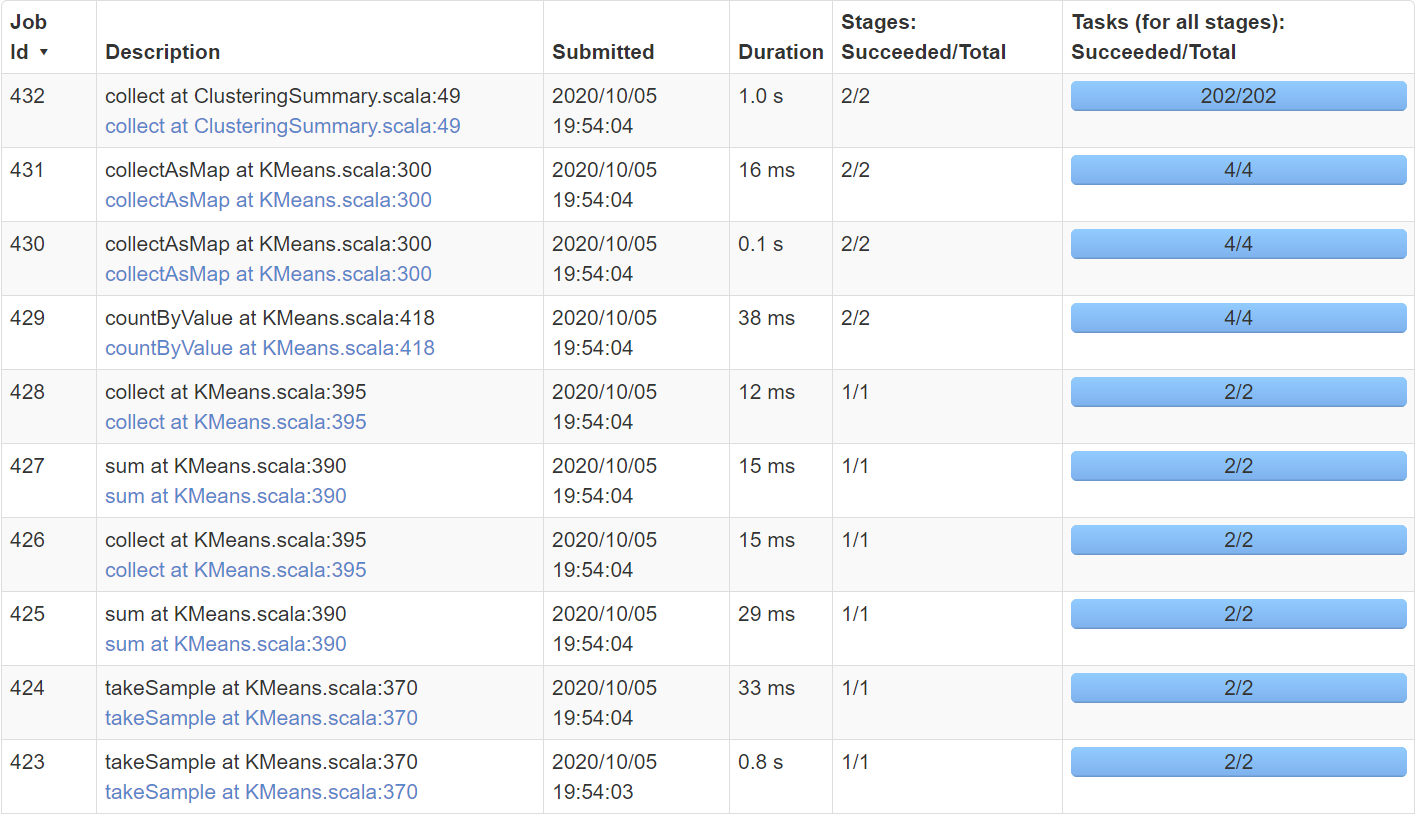

10 jobs are observed when training the KMeans clustering model.

#### 3.2 Combining the KMeans algorithm from the lecture, explain what each job in Spark UI represents

#### ● 300 words max for the discussion

####  ● Hint - you can also refer to the Spark source code on github
https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/clustering/KMeans.scala
https://stackoverflow.com/questions/46236955/when-running-spark-mllib-kmeans-what-is-the-role-of-each-stage-on-website

K-means is an iterative algorithm, where in each iteration points are assigned to the nearest centroid and centroids are updated based on the assigned points. This process is repeated until convergence criteria is met. We have found there were 10 jobs when training the KMeans clustering model. These jobs can be classified into 6 categories, as follows:

* takeSample: Assign initial values for the k=3 seed cluster centroids into each processor randomly 
* sum: Assign each data point to the cluster which has the closest mean in each processor 
* collect at KMeans: Collect each data points in the same cluster in each processor
* countByValue: Count the number of data points in each cluster to re-calculate the mean
* collectAsMap: Each data point is fetched to the driver and broadcasted to be used in the next iteration
* collect at ClusteringSummary: Collect each data points in each cluster across all the processors to find the best centroids and assign data points into an appropriate cluster. It is repeated until the clusters are stable(no change of memebers)